# Pronósticos Usando Deep Learning
## ¡Un Pronóstico Probabilístico!

¡Hola de nuevo! Anteriormente realizamos un ejercicio para pronosticar el consumo de energía eléctrica de 370 consumidores en USA. Nuestro problema sigue siendo el mismo, es decir:

![context](imgs/context.png)

Sin embargo, a lo largo de este ejercicio daremos un paso más allá. Y es que nuestro pronóstico no será únicamente un pronóstico puntual, sino que generaremos toda una distribución al rededor de sus posibles valores.

Este ejercicio será guiado, pero dependerá de ti resolverlo y experimentar. 

Completa el código donde veas la indicación `### TU CÓDIGO AQUÍ ###`

<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" href="https://colab.research.google.com/github/juancop/URDeepLearning/blob/main/Forecasting/Pron%C3%B3stico%20Probabil%C3%ADstico.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/juancop/URDeepLearning/blob/main/Forecasting/Pron%C3%B3stico%20Probabil%C3%ADstico.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  
</table>

Si estás en colab corre la siguiente celda:

In [ ]:
!git clone https://github.com/juancop/URDeepLearning && mv URDeepLearning/Forecasting/sample .

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
np.random.seed(42)

In [4]:
tf.__version__ # ¡Verifica nuevamente que estés usando la versión 2.3.1!

'2.3.1'

## Carga de Información

In [5]:
df = pd.read_csv('sample/electricity.csv')

In [11]:
df.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,1.586294,30960.0,1290,MT_001,2014-07-14 00:00:00,MT_001,0,14,0,7,30960.0,0,0
1,1.269036,30961.0,1290,MT_001,2014-07-14 01:00:00,MT_001,1,14,0,7,30961.0,0,1
2,1.269036,30962.0,1290,MT_001,2014-07-14 02:00:00,MT_001,2,14,0,7,30962.0,0,2
3,1.269036,30963.0,1290,MT_001,2014-07-14 03:00:00,MT_001,3,14,0,7,30963.0,0,3
4,1.586294,30964.0,1290,MT_001,2014-07-14 04:00:00,MT_001,4,14,0,7,30964.0,0,4


# Datos para Entrenamiento

En este punto estmaos ya familiarizados con la información que estamos trabajando, por lo que nos saltaremos la exploración de los datos. 

La generación de ventanas de entrenamiento es bastante importante, pues a partir de ellas el modelo aprende. En esta sección te encargarás de crear una función de procesamiento que te entregue la variable objetivo como la desees (ya sea con o sin logaritmo) y el conjunto de variables explicativas que quieras usar. 

In [46]:
class processElectricityDataFrame:
    """
    Procesa el DataFrame para generar un data set de ventanas.
    """
    
    def __init__(self, train_df, val_df, test_df, index_variable, target_variable,
                input_window, output_window, step = 24):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df   
        
        self.label_name = target_variable
        self.input_window = input_window
        self.output_window = output_window
        self.index_variable = index_variable
        self.step = step
        
        
        self.model_columns = None 
            
    
    def create_npy_dataset(self, df, folder, name, columns, input_window, output_window, label_name):
        """
            df: DataFrame a utilizar
            folder: Folder para almacenar el .npy
            columns: Lista de las columnas que se utilizarán al final
            name: Nombre para el archivo (train, val, test)
            input_window: Tamaño de la ventana de entrada (12)
            output_window: Tramaño de la ventana de salida (12)
            label_name: Nombre de la variable objetivo
        
        """
        file_input = os.path.join(folder, f'input_{name}.npy')
        file_output = os.path.join(folder, f'output_{name}.npy')

        unique_id_names = df[self.index_variable].value_counts().index.values
        npy_input = None
        npy_output = None

        label_index = columns.index(label_name)
        input_columns = columns.copy()
            
        window_size = input_window + output_window
        
        print(f'Started .npy creation with name: {name}')
        for id_name in tqdm(unique_id_names):
            
            customer_df = df[df[self.index_variable] == id_name].sort_values(by = 'date').copy()
            output_tmp_df = customer_df[columns].values
            input_tmp_df = customer_df[input_columns].values
            n_windows = len(output_tmp_df) - window_size + 1
            
            input_array = np.expand_dims(np.arange(self.input_window), 0) +  np.expand_dims(np.arange(n_windows, step = self.step), 0).T
            output_array = np.expand_dims(np.arange(self.output_window), 0) + self.input_window +  np.expand_dims(np.arange(n_windows, step = self.step), 0).T
            
            
            inputs = input_tmp_df[input_array].astype(np.float32)
            labels = output_tmp_df[output_array, label_index].astype(np.float32)
            
            if npy_input is None:
                
                npy_input = inputs
                npy_output = labels
            else:
                
                npy_input = np.append(npy_input, inputs, axis = 0)
                npy_output = np.append(npy_output, labels, axis = 0)
                
                random_index = np.random.choice(npy_input.shape[0], npy_input.shape[0], replace=False)
                
                npy_input = npy_input[random_index, :, :]
                npy_output = npy_output[random_index, :]
                
        #npy_output = np.repeat(npy_output[:, :, np.newaxis], 3, axis=2)

        with open(file_input, 'wb') as f:
            np.save(f, npy_input)

        with open(file_output, 'wb') as f:
            np.save(f, npy_output)

        print('Completed .npy creation.')        

        
    def preprocess_fn(self, df, model_type):      
        if model_type == 'raw_inf':
            df[self.label_name] = np.log(df[self.label_name] + 1)
            self.model_columns = [self.label_name]#, 'hour', 'day_of_week', 'month']
            return df
        
        
        ### TU CÓDIGO AQUÍ ####
        
        # Define tu función de procesamiento e indica en self.model_columns las variables que utilizarás para entrenar
        # OJO: La variable objetivo debe ser la primera en la lista.
        
        # Esta función debe retornar un data frame con todas las variables que definiste
        
        if model_type == 'no_log':
            self.model_columns = [self.label_name]
            return df
        
        ### TERMINA ###

        
    def create_all_datasets(self, folder_name = 'data', model_type = 'raw_inf'):
        
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
        
        train_df = self.preprocess_fn(self.train_df, model_type)    
         
        self.create_npy_dataset(df = train_df, folder = folder_name, name = 'train', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)
        
        val_df = self.preprocess_fn(self.val_df, model_type)    
         
        self.create_npy_dataset(df = val_df, folder = folder_name, name = 'val', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)
        
        
        test_df = self.preprocess_fn(self.test_df, model_type)    
         
        self.create_npy_dataset(df = test_df, folder = folder_name, name = 'test', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)

In [118]:
test_df = df[df.date >= '2014-08-31']
val_df = df[(df.date >= '2014-08-24') & (df.date < '2014-08-31')]
train_df = df[df.date < '2014-08-24']


A continuación generaremos los datos para el modelo. ¡Sí! Con las ventanas y la función de procesamiento que definiste.

In [119]:
df_process = processElectricityDataFrame(train_df, 
                                         val_df, 
                                         test_df, 
                                         index_variable = 'categorical_id',
                                         target_variable = 'power_usage',
                                         input_window = 48,
                                         output_window = 24,
                                         step = 3)

In [120]:
df_process.create_all_datasets(folder_name = 'data', model_type = 'no_log')

Started .npy creation with name: train


100%|██████████| 369/369 [00:21<00:00, 17.36it/s]


Completed .npy creation.
Started .npy creation with name: val


100%|██████████| 369/369 [00:06<00:00, 59.27it/s]


Completed .npy creation.
Started .npy creation with name: test


100%|██████████| 369/369 [00:01<00:00, 207.90it/s]

Completed .npy creation.


# Pronóstico Probabilístico

Hasta este punto no hemos hecho nada raro. ¿Cómo hacemos que nuestro modelo prediga un cuantil si ni siquiera conocemos la distribución subyacente a cada serie? La respuesta se encuentra en lo que se conoce como *Quantile Loss*, o también *Pinball Loss*.  ¿Te suena la métrica conocida como $\operatorname{MAD}$? En el contexto de regressión lineal, si el criterio es minimizar la $\operatorname{MAD}$ (Median Absolute Deviation), estaríamos haciendo una regresión sobre la *mediana* en lugar de la media. 

Esta función de pérdida viene dada por, 

$$QL(y, \hat{y}, \tau) = \operatorname{max}(\tau (y - \hat{y}), (1 - \tau)(\hat{y} - y))$$

A modo de ejemplo, si $\tau = 0.75$, la función se vería como:

$$QL(y, \hat{y}, \tau) = \operatorname{max}(0.75 (y - \hat{y}), 0.25(\hat{y} - y))$$

donde el modelo penalizaría más fuertemente una predicción por encima de $y$ que una por debajo. Lo que se busca es que los errores de predicción por encima sean apenas el 25% de las veces, mientras que por debajo sean el 75% de las veces. 

Dicho lo anterior, completa la función de pérdida para nuestro problema, asumiendo que `y_true` es un vector de dimensión `(N, T)` y `y_pred`es de dimensión `(N, T, q)`, donde: 
1. `N` Es la cantidad de individuos
2. `T` Es la cantidad de puntos en el tiempo (el horizonte de pronóstico)
3. `q` corresponde a la cantidad de cuantiles estimados


Utiliza las siguientes funciones para completar el código: 
- ``tf.math.subtract``: https://www.tensorflow.org/api_docs/python/tf/math/subtract
- ``tf.math.multiply``: https://www.tensorflow.org/api_docs/python/tf/math/multiply
- ``tf.math.maximum``: https://www.tensorflow.org/api_docs/python/tf/math/maximum


In [103]:
from tensorflow.keras.losses import Loss

class QuantileLoss(Loss):
    
    def __init__(self, percentiles = [0.1, 0.5, 0.9]):
        super().__init__()
        self.percentiles = percentiles
        self.n_quantiles = len(self.percentiles)

    def call(self, y_true, y_pred):
        """
        Computes the Quantile Loss
        """
        
        percentiles = tf.constant(self.percentiles, shape = [1, self.n_quantiles], dtype = float)
        
        # Redimensionamos el vector objetivo para repetir sus columnas por cada cuantil a estimar
        y_true = tf.expand_dims(y_true, -1)
        y_true = tf.repeat(y_true, repeats = self.n_quantiles, axis=-1)
        
        
        ### TU CÓDIGO ###
        # Calcula el error de predicción (y - yhat)
        error = tf.math.subtract(y_true, y_pred)
        
        ### TERMINA ###
        
        under_prediction_error = tf.math.multiply(percentiles, error) # Cálculo de primer término
        
        ### TU CÓDIGO ###
        # Calcula el segundo término de error
        over_prediction_error = tf.math.multiply((percentiles - 1), error)
        
        ### TERMINA ###
        
        ### TU CÓDIGO ###
        # Calcula la pérdida utilizando el máximo
        Quantile_Loss = tf.math.maximum(under_prediction_error, over_prediction_error)
        
        ### TERMINA ###
        return tf.math.reduce_mean(Quantile_Loss)

¡Verifica tu resultado!

Debes obtener:

`<tf.Tensor: shape=(), dtype=float32, numpy=1.2333332>`


In [106]:
y_true = tf.constant([1, 2, 3], dtype = float)
y_pred =  tf.constant([4, 5, 6], dtype = float)

QL = QuantileLoss()
QL.call(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2333332>

# Entrenamiento de Modelo

In [51]:
def load_dataset(path_to_features, path_to_labels):
    features = np.load(path_to_features)
    labels = np.load(path_to_labels)
    
    assert features.shape[0] == labels.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(256)
    return dataset

In [52]:
train_features = os.path.join('data', 'input_train.npy')
train_labels = os.path.join('data', 'output_train.npy')
train_dataset = load_dataset(train_features, train_labels)

val_features = os.path.join('data', 'input_val.npy')
val_labels = os.path.join('data', 'output_val.npy')
val_dataset = load_dataset(val_features, val_labels)

test_features = os.path.join('data', 'input_test.npy')
test_labels = os.path.join('data', 'output_test.npy')
test_dataset = load_dataset(test_features, test_labels)

In [53]:
def validate_inf(arrays):
    for array in arrays:
        loaded_array = np.load(os.path.join(array))
        n_inf = np.isinf(loaded_array).sum()
        if n_inf:
            print(f'Array {array} contains INF values')
            
        n_nan = np.isnan(loaded_array).sum()
        if n_nan:
            print(f'Array {array} contains NAN values')

¡Listo! Podremos realizar el entrenamiento de nuestro modelo. Para poderlo hacer necesitarás definir dos cosas:

1. ¿Qué percentiles utilizarás? Por defecto tenemos el percentil 10%, 50% y 90%, pero puedes definir otros diferentes.
2. ¡Claramente la arquitectura de red!

In [85]:
OUT_STEPS = 24

### TU CÓDIGO AQUÍ ###

# Define los percentiles que quieres estimar en una lista (e.g. [0.1, 0.5, 0.9])
PERCENTILES = [0.1, 0.5, 0.9]

### TERMINA ###

percentiles = len(PERCENTILES)


model = tf.keras.models.Sequential([
                ### TU CÓDIGO AQUÍ ###
                # Define la arquitectura de red que quieras utilizar, no definas la capa de salida
    
                tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.LSTM(32, return_sequences=False, activation='relu'),
    
                ### TERMINA ###
                tf.keras.layers.Dense(OUT_STEPS*percentiles, kernel_initializer=tf.initializers.zeros()),
                tf.keras.layers.Reshape((OUT_STEPS, percentiles))
                ])

In [86]:

checkpoint_folder = 'training/'
tf_log_dir = 'training/logs'

if not os.path.exists(checkpoint_folder):
    os.mkdir(checkpoint_folder)
    
if not os.path.exists(tf_log_dir):
    os.mkdir(tf_log_dir)


In [87]:
name = 'pfcst'
execution_time = datetime.now().strftime("%Y%m%d-%H%M%S")
tf_log_dir = 'training'
logdir = f"{tf_log_dir}/probabilistic/{name}_{execution_time}" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_path = f"{checkpoint_folder}/checkpoints_{name}_{execution_time}/cp.ckpt"
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

### TU CÓDIGO AQUÍ
# Define tu Early Stopping Callback

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### TERMINA

In [88]:
### TU CÓDIGO AQUÍ
# Define el otpimizador que vas a utilizar y sus parámetros
optimizer = tf.optimizers.Adam(learning_rate=0.001)

### TERMINA 

EPOCHS = 200

model.compile(
      optimizer=optimizer,
      loss=QuantileLoss(),# tf.losses.MeanSquaredError(),
     
    )

In [90]:
model.fit(train_dataset, validation_data=val_dataset, 
              callbacks=[tensorboard_callback, checkpoints_callback, earlystopping_callback],
              epochs=EPOCHS, verbose =1) 
    

Epoch 1/200
440/440 [==============================] - ETA: 0s - loss: 334.7629
Epoch 00001: val_loss improved from inf to 183.72473, saving model to training//checkpoints_random_dropout_0.05_20220510-233112/cp.ckpt
440/440 [==============================] - 111s 253ms/step - loss: 334.7629 - val_loss: 183.7247
Epoch 2/200
440/440 [==============================] - ETA: 0s - loss: 209.5303
Epoch 00002: val_loss did not improve from 183.72473
440/440 [==============================] - 116s 263ms/step - loss: 209.5303 - val_loss: 334.8266
Epoch 3/200
440/440 [==============================] - ETA: 0s - loss: 150.9754
Epoch 00003: val_loss improved from 183.72473 to 148.51752, saving model to training//checkpoints_random_dropout_0.05_20220510-233112/cp.ckpt
440/440 [==============================] - 103s 235ms/step - loss: 150.9754 - val_loss: 148.5175
Epoch 4/200
440/440 [==============================] - ETA: 0s - loss: 136.3994
Epoch 00004: val_loss improved from 148.51752 to 125.88783

Para este punto ya tenemos un modelo entrenado, y el mejor dada la configuración se encuentra almacenado en `checkpoint_path`. A continuación vamos a observar sus resultados y hacer una pequeña evaluación. 

In [91]:
model.load_weights(checkpoint_path)

In [92]:
model.evaluate(test_dataset)

60/60 [==============================] - 5s 78ms/step - loss: 78.0283


78.02826690673828

In [93]:
model.evaluate(val_dataset)

48/48 [==============================] - 4s 77ms/step - loss: 85.0633


85.06327819824219

# Análisis de Desempeño

Carga los datos de prueba y realiza la predicción del modelo.

In [125]:
X = np.load(test_features)
Y = np.load(test_labels)

In [126]:
### TU CÓDIGO AQUÍ
Y_hat = model.predict(X)

### TERMINA

A continuación, deberás definir la función que graficará tus resultados. Ten en cuenta que debes realizar las transformaciones inversas a las que aplicaste en la generación de ventanas.

In [127]:
def plot_predictions(Y_past, Y_true, Y_pred, idx_obs, exponent = True):
    plt.figure(figsize = (10, 5))
    input_length = Y_past.shape[1]
    ouput_length = Y_pred.shape[1]
    if not exponent:
        plt.plot(np.arange(input_length), Y_past[idx_obs, :, 0], color = 'black')
        
        ### TU CÓDIGO AQUÍ ###
        # Grafica la serie objetivo y la serie predicha para un idx_obs particular
        plt.plot(np.arange(input_length, input_length+ouput_length), Y_true[idx_obs,: ], color = 'black', label = 'True Usage', linestyle = '--')
        plt.plot(np.arange(input_length, input_length+ouput_length), Y_pred[idx_obs, :, 1], color = 'red', label = 'Prediction')
        
        ### TERMINA ###
        
        # Asumimos que el cuantil más bajo es el primero y el más alto es el último
        plt.fill_between(np.arange(input_length, input_length+ouput_length), Y_pred[idx_obs, :, 0], Y_pred[idx_obs, :, -1], color='b', alpha=.1)
        
    else:
        ### Un ejemplo si requiriéramos realizar exponenciación
        plt.plot(np.arange(input_length), np.exp(Y_past[idx_obs, :, 0]) - 1, color = 'black')
        plt.plot(np.arange(input_length, input_length+ouput_length), np.exp(Y_true[idx_obs,: ]) - 1, color = 'black', label = 'True Usage', linestyle = '--')
        plt.plot(np.arange(input_length, input_length+ouput_length), np.exp(Y_pred[idx_obs, :, 1]) - 1, color = 'red', label = 'Prediction')
        plt.fill_between(np.arange(input_length, input_length+ouput_length), np.exp(Y_pred[idx_obs, :, 0]) - 1, np.exp(Y_pred[idx_obs, :, 2]) - 1, color='b', alpha=.1)
    plt.legend()

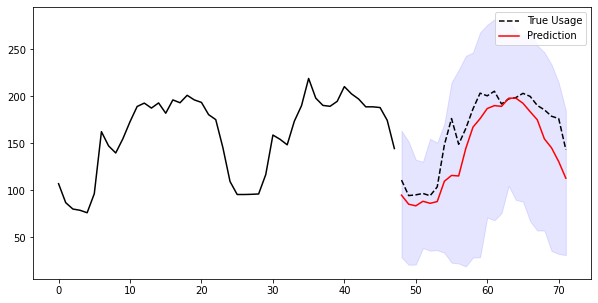

In [129]:
plot_predictions(X, Y, Y_hat, 3, False)

Ya que tenemos una función para graficar nuestras predicciones, vamos a hacer el cálculo del MAPE de cada serie y del modelo en general. 

In [130]:
def compute_mape(Y_true, Y_pred, return_list = True):

    Y_true = Y_true + 1
    ### TU CÓDIGO AQUÍ ###
    # Escoge el quantil sobre el cual vas a hacer la comparación (principalmente sería la mediana)
    Y_pred = Y_pred[:, :, 1]
        
    ### TERMINA
    
    Y_pred = Y_pred.clip(min = 1)
    
    ### TU CÓDIGO AQUÍ ###
    # Calcula el MAPE para cada serie
    abs_error = abs(Y_true - Y_pred)
    
    APE = abs_error/Y_true
    MAPE_customer = np.mean(APE, axis = 1) # Una lista de MAPE de dimensión Y_true.shape[0]
    
    ### TERMINA ###
    print('Overall model MAPE: {:.2%}'.format(np.mean(MAPE_customer)))
    print('Overall model MAPE (median): {:.2%}'.format(np.median(MAPE_customer)))
    return MAPE_customer
    

In [131]:
def compute_mape(Y_true, Y_pred, return_list = True, exponent = True):
    if exponent:
        Y_true = np.exp(Y_true)
        Y_pred = np.exp(Y_pred[:, :, 1]) - 1
    else:
        Y_true = Y_true + 1
        Y_pred = Y_pred[:, :, 1]
        
    Y_pred = Y_pred.clip(min = 0)
    
    abs_error = abs(Y_true - Y_pred)
    
    APE = abs_error/Y_true
    MAPE_customer = np.mean(APE, axis = 1)
    print('Overall model MAPE: {:.2%}'.format(np.mean(MAPE_customer)))
    print('Overall model MAPE (median): {:.2%}'.format(np.median(MAPE_customer)))
    return MAPE_customer
    

In [132]:
def plot_ranked(Y_true, Y_pred, X, mape, best = True, top = 5, exponent = True):
    sorted_mape = np.argsort(mape)
    if best:
        idx = sorted_mape[:top]
    else:
        idx = sorted_mape[-top:]
    for i in idx:
  
        plot_predictions(X, Y_true, Y_pred, i, exponent)
        plt.title("{:.2%}".format(mape[i]))
        plt.plot()

In [133]:
mape_list = compute_mape(Y, Y_hat, exponent = False)

Overall model MAPE: 67.79%
Overall model MAPE (median): 21.28%


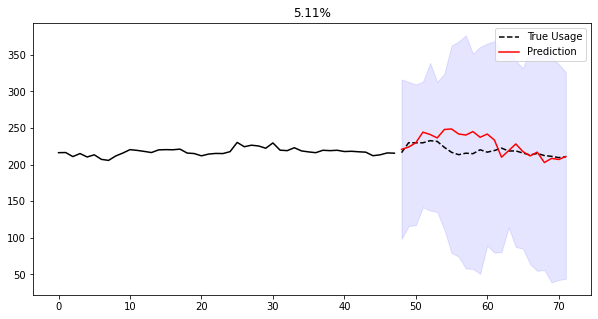

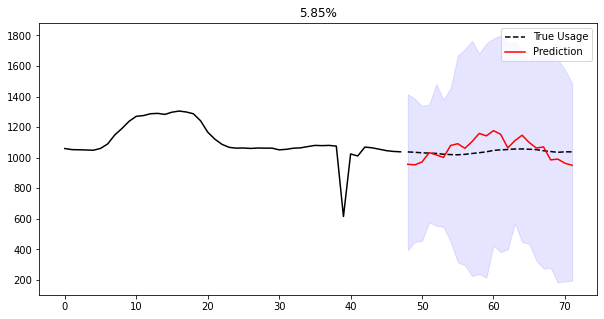

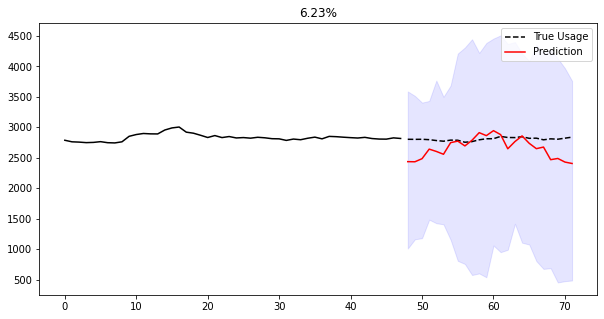

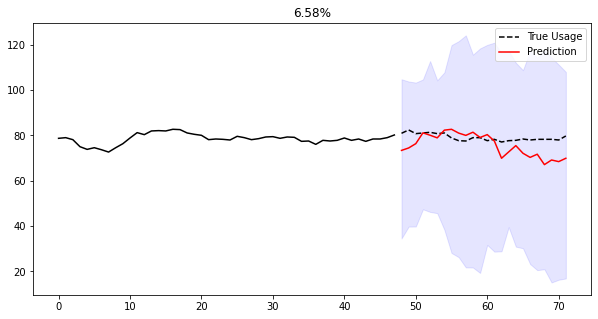

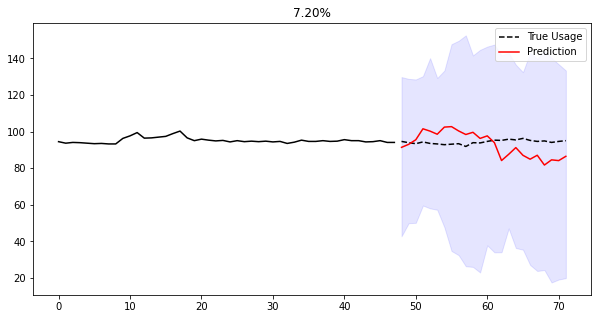

In [134]:
plot_ranked(Y, Y_hat, X, mape_list, exponent = False)

#plot_predictions(X, Y, Y_hat, 28)

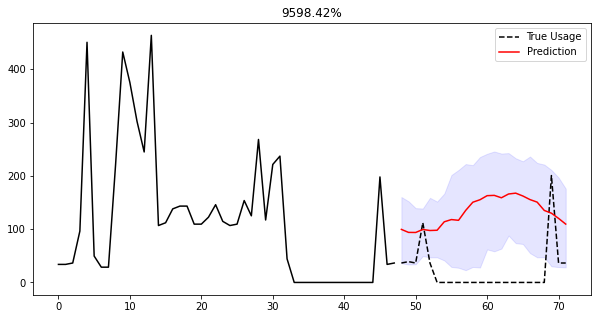

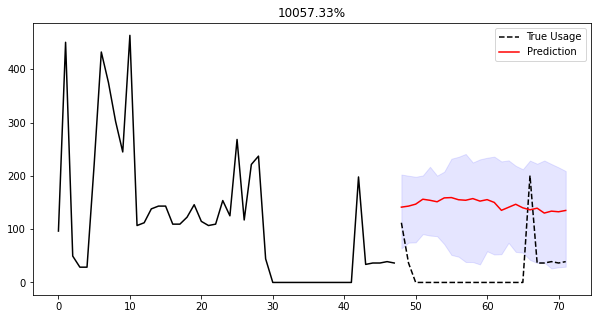

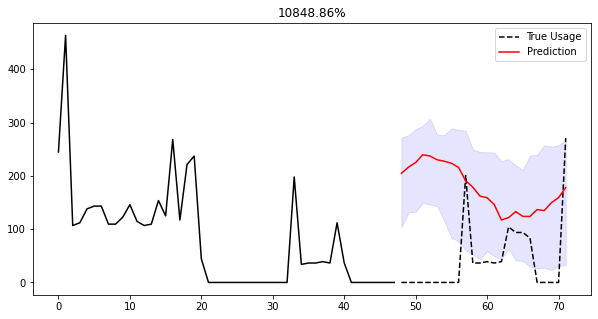

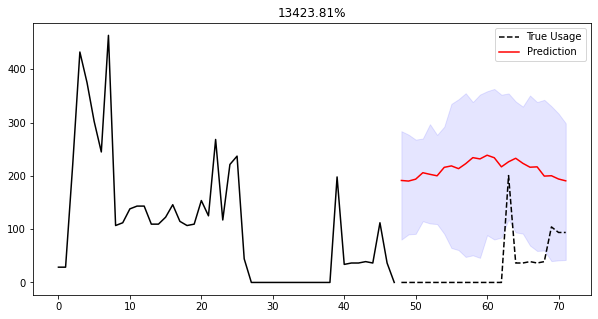

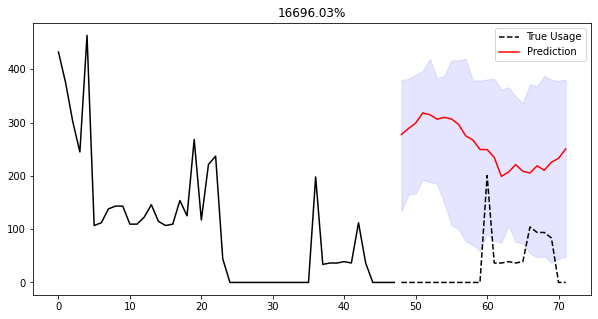

In [102]:
plot_ranked(Y, Y_hat, X, mape_list, exponent = False, best = False)

#plot_predictions(X, Y, Y_hat, 28)